In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
import torchvision.models as models
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from torchvision import transforms


cudnn.benchmark = True

In [47]:
TRAIN_DIR = '/kaggle/input/raf-db-train-test-val-mtcnn/mtcnn_preprocess/train'
TEST_DIR = '/kaggle/input/raf-db-train-test-val-mtcnn/mtcnn_preprocess/test'
VAL_DIR = '/kaggle/input/raf-db-train-test-val-mtcnn/mtcnn_preprocess/val'

In [48]:
train = pd.read_csv(
    '/kaggle/input/raf-db-train-test-val-mtcnn/mtcnn_preprocess/train.csv',
    sep=' ',
)
test = pd.read_csv(
    '/kaggle/input/raf-db-train-test-val-mtcnn/mtcnn_preprocess/test.csv',
    sep=' ',
)
val = pd.read_csv(
    '/kaggle/input/raf-db-train-test-val-mtcnn/mtcnn_preprocess/val.csv',
    sep=' ',
)

In [49]:
train['label'] = train[['label']].apply(lambda x: x - 1)
test['label'] = test[['label']].apply(lambda x: x - 1)
val['label'] = val[['label']].apply(lambda x: x - 1)

In [50]:
train

,name,label
0,train_00001.jpg,4
1,train_00002.jpg,4
2,train_00003.jpg,3
3,train_00004.jpg,3
4,train_00005.jpg,4
...,...,...
10468,train_12267.jpg,6
10469,train_12268.jpg,6
10470,train_12269.jpg,6
10471,train_12270.jpg,6


## Dataloaders

In [51]:
class ImageData(Dataset):
    def __init__(self, df, data_dir, transform=None):
        super().__init__()
        self.df = df
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name = f'{self.data_dir}/{self.df.iloc[index]["name"]}'
        label = self.df.iloc[index]["label"]
        
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

class ImageDataInference(Dataset):
    def __init__(self, df, data_dir, transform=None):
        super().__init__()
        self.df = df
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name = f'{self.data_dir}/{self.df.iloc[index]["name"]}'
        
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image

In [52]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

## Augmentation

In [53]:
train_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((384, 384)),
        transforms.TrivialAugmentWide(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

val_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((384, 384)),
#         transforms.TrivialAugmentWide(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

test_transform = transforms.Compose(
    [    
        transforms.ToPILImage(),
        transforms.Resize((384, 384)),
#         transforms.TrivialAugmentWide(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

In [54]:
dataset = ImageData(train, TRAIN_DIR, train_transform)

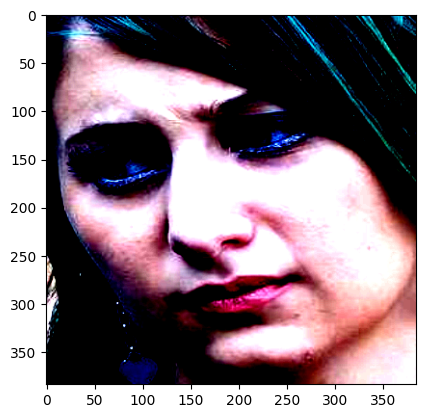

In [55]:
plt.imshow(dataset[0][0].permute(1, 2, 0))

## Heplers

In [56]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [57]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [58]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [59]:
class MyEfficientNet(ImageClassificationBase):
    def __init__(self, model):
        super().__init__()
        self.network = model
        
    def forward(self, xb):
        return self.network(xb)

## Load data

In [60]:
DEVICE = get_default_device()

In [61]:
train_dataset = ImageData(train, TRAIN_DIR, train_transform)
val_dataset = ImageData(val, VAL_DIR, val_transform)
test_dataset = ImageDataInference(test, TEST_DIR, test_transform)

In [62]:
batch_size=24
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size, num_workers=4, pin_memory=True)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [63]:
train_dataloader = DeviceDataLoader(train_dataloader, DEVICE)
val_dataloader = DeviceDataLoader(val_dataloader, DEVICE)
test_dataloader = DeviceDataLoader(test_dataloader, DEVICE)

## Model

In [64]:
import torchvision.models as models
import torch.nn as nn

efficient_net = models.efficientnet_v2_s(pretrained=True)
for params in efficient_net.parameters():
    params.requires_grad = True

n_features = efficient_net.classifier[1].in_features
efficient_net.classifier = nn.Sequential(
  nn.Linear(in_features=n_features, out_features=1024),
  nn.ReLU(),
  nn.Linear(in_features=1024, out_features=512),
  nn.ReLU(),
  nn.Dropout(p=0.6), 
    
  nn.Linear(in_features=512 , out_features=7),
  nn.LogSoftmax(dim=1)  
)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [65]:
model = MyEfficientNet(efficient_net)
model = to_device(model, DEVICE)

## TRAIN

In [66]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
#     print(outputs)
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, optimizer, scheduler=None):
    history = []
    for epoch in range(epochs): 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        
        if scheduler is not None:
            scheduler.step()

    return history

In [67]:
evaluate(model, val_dataloader)

{'val_loss': 1.9441691637039185, 'val_acc': 0.08067375421524048}

In [68]:
epochs = 10
lr = 0.0001
opt_func = torch.optim.Adam
optimizer = opt_func(model.parameters(), lr)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.00001)

history = fit(epochs, lr, model, train_dataloader, val_dataloader, optimizer, scheduler)

Epoch [0], train_loss: 1.2940, val_loss: 0.7657, val_acc: 0.7491
Epoch [1], train_loss: 0.8359, val_loss: 0.6418, val_acc: 0.7793
Epoch [2], train_loss: 0.6353, val_loss: 0.5687, val_acc: 0.8023
Epoch [3], train_loss: 0.4822, val_loss: 0.5938, val_acc: 0.7961
Epoch [4], train_loss: 0.3639, val_loss: 0.5961, val_acc: 0.8165
Epoch [5], train_loss: 0.2889, val_loss: 0.5546, val_acc: 0.8369
Epoch [6], train_loss: 0.2254, val_loss: 0.5692, val_acc: 0.8254
Epoch [7], train_loss: 0.1812, val_loss: 0.5669, val_acc: 0.8484
Epoch [8], train_loss: 0.1492, val_loss: 0.5910, val_acc: 0.8475
Epoch [9], train_loss: 0.1376, val_loss: 0.5947, val_acc: 0.8457


In [69]:
PATH = "/kaggle/working/efficient_net_mtcnn.pth"

torch.save(model.state_dict(), PATH)

In [70]:
while True:
    ...

KeyboardInterrupt: 

In [71]:
test_dataset = ImageData(test, TEST_DIR, test_transform)

batch_size=16
test_dataloader = DataLoader(test_dataset, batch_size, num_workers=4, pin_memory=True)
test_dataloader = DeviceDataLoader(test_dataloader, DEVICE)

In [72]:
evaluate(model, test_dataloader)

{'val_loss': 0.632993757724762, 'val_acc': 0.8407458662986755}